In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

<h2>SVM Analysis</h2>
This classifier separates data points using a hyperplane with the largest amount of margin. This model finds an optimal hyperplane which can help in classifying new data points. It is often used for classification problems which satisfies our binary classification use case. 

The goal of SVM is to find a maximum marginal hyperplane that best divides the dataset into classes. Support vectors are the data points closest to the hyperplane. 

<strong>How does SVM work?</strong>

[1] Generate hyperplanes which separates the classes in the best way. 
[2] Select the right hyperplane with maximum separation from the nearest points that define the boundary. Given non-linear and inseparable planes, kernal tricks can be used to transform the input space to a higher dimensional space.

<strong>Scikit Learn Tuning Parameters</strong>

[1] From the EDA, it was difficult to see any prominent relationships between the outputs and inputs. For that reason, we test SVC and NuSVC SVM's disregarding LinearSVC. SVC and NuSVC simply vary in their mathematical formulations.

[2] Kernel: Specifies the kernel type to be used in the algorithm. Some possible values are linear, poly, rbf, sigmoid, or precomputed.

[3] C: The strength of regularization => for SVC 

[4] Degree of the polynomial

[5] class_weight: Given that we have many positive and few negative, balancing the class weight might be something of interest.

[6] gamma (scale or auto): Useful for non-linear kernal like RBF. This defines the behavior of the decision boundary.

Sources:
https://scikit-learn.org/stable/modules/svm.html

https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

<strong>Defining ROC and AUC Score Function</strong>

In [11]:
def predictive_probability_results(y_true, y_prob, label="Model", title="ROC Curve"):
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
filename = '/kickstarter_one_hot_cleaned.csv'
filepath = '/Users/zarahtaufique/Desktop/SJSU/Year4Semester2/CMPE188/kickstarter-project-success-predictions/data'
pd.set_option('display.max_columns', None)

full_kickstarter_df = pd.read_csv(filepath+filename, low_memory=False)
print(full_kickstarter_df.columns)

Index(['goal', 'backers_count', 'static_usd_rate', 'usd_pledged',
       'name_len_clean', 'blurb_len_clean', 'deadline_month', 'deadline_day',
       'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_hr',
       'launched_at_month', 'launched_at_day', 'launched_at_yr',
       'launched_at_hr', 'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days', 'TOPCOUNTRY', 'LaunchedTuesday',
       'DeadlineWeekend', 'name', 'blurb', 'disable_communication', 'country',
       'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at',
       'staff_pick', 'category', 'spotlight', 'deadline_weekday',
       'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday',
       'create_to_launch', 'launch_to_deadline', 'launch_to_state_change',
       'SuccessfulBool', 'category_grouped', 'currency_grouped',
       'country_grouped', 'app', 'help', 'new', 'world', 'canceled'],
      dtype='object')


In [13]:
# Dropping columns before training
cols_to_drop = [
    'name',
    'blurb',
    'category',
    'country',
    'currency',
    'deadline',
    'state_changed_at',
    'created_at',
    'launched_at',
    'launch_to_state_change',
    'create_to_launch',
    'launch_to_deadline',
    'currency_grouped',
    'category_grouped',
    'country_grouped',
    'spotlight' # Manually dropping the spotlight column as this is a source for data leakage
]

features_to_drop = ['usd_pledged', 'staff_pick', 'backers_count']
starter_df = full_kickstarter_df.drop(cols_to_drop, axis=1)

def safe_drop_columns(df, features_to_drop):
    for column in features_to_drop:
        if column in df.columns.tolist():
            df.drop(column, axis=1, inplace=True)
safe_drop_columns(starter_df, features_to_drop)
print(starter_df.head())

       goal  disable_communication  static_usd_rate  name_len_clean  \
0    1500.0                      0         1.000000               9   
1     500.0                      0         1.000000               4   
2  100000.0                      0         1.000000               8   
3    5000.0                      0         1.000000               6   
4    3222.0                      0         1.114613               7   

   blurb_len_clean  deadline_month  deadline_day  deadline_hr  \
0               16               1            23           10   
1               15               5             1           16   
2               10               3            26            8   
3               13              10             6            0   
4               18               6            27           12   

   created_at_month  created_at_day  created_at_hr  launched_at_month  \
0                11              29             22                 12   
1                 2              20 

Many columns are labeled with true/false variables. SVMs are mathematical models requiring numerical inputs. 

In [14]:
for col in starter_df.columns:
    if starter_df[col].dtype == bool:
        starter_df[col] = starter_df[col].astype(int)

In [43]:
# Encode weekday columns (from names to numbers if needed)
days_cols = ['deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday']
weekday_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}

starter_df[days_cols] = (
    starter_df[days_cols]
    .replace(weekday_map)
    .infer_objects(copy=False)
)

/var/folders/8m/mq73xyj94h5fkfc5t6y23vkr0000gn/T/ipykernel_1221/2920319086.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(weekday_map)


In [44]:
print(starter_df.dtypes)

goal                          float64
disable_communication           int64
static_usd_rate               float64
name_len_clean                  int64
blurb_len_clean                 int64
                               ...   
category_grouped_Plays          int64
category_grouped_Software       int64
category_grouped_Sound          int64
category_grouped_Wearables      int64
category_grouped_Web            int64
Length: 74, dtype: object


<h3>Preliminary Analysis with Minimal Model Tuning</h3>

In [15]:
# All input features
X = starter_df.drop('SuccessfulBool', axis=1)

# Get the output
Y = starter_df['SuccessfulBool']

models = [
    ('RBF SVC SVM', SVC(kernel='rbf', C=1, random_state=42)), # RBF is the default for SVM
    ('RBF NuSVC SVM', NuSVC(kernel='rbf', random_state=42)),
]

In [90]:
results = []
preliminary_results = []
names = []
scoring = 'accuracy'
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} accuracy (±{cv_results.std():.4f})")

RBF SVC SVM: 0.7083 accuracy (±0.0090)
RBF NuSVC SVM: 0.3301 accuracy (±0.0232)


<h3>Analysis of Different Kernel Functions</h3>

<strong>Kernal Function Notes</strong>
The kernel function is used to take data as input and transform it into the required form of processing data.

[1] Linear Kernel: This is best suited for data that is linearly separable. From EDA, we did not see much linear correlation between the input and output data. As a result, we skip this kernel.

[2] Polynomial Kernel: This allows for mapping of more complex relationships by introducing polynomial terms. This is useful for data that is not linearly separable but still follows a pattern.

[3] RBF Kernel: This is the most widely used kerne;. It maps the data into an infinite-dimensional space marking it highly effective for complex classification problems. We use this when the decision boundary is highly non-linear.

[4] Sigmoid: This is inspired by neural networks. It is suitable for neural networks and non-linear classifiers.

Source: https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/
A cool video for kernal visualization: https://www.youtube.com/watch?v=3liCbRZPrZA

In [ ]:
kernel_models = [
    ('Poly SVC SVM', SVC(kernel='poly', C=1, random_state=42)),
    ('Sigmoid SVC SVM', SVC(kernel='sigmoid', C=1, random_state=42)),

    ('Poly NuSVC SVM', NuSVC(kernel='poly', random_state=42)),
    ('Sigmoid NuSVC SVM', NuSVC(kernel='sigmoid', random_state=42))
]

kernel_results = []
kernel_preliminary_results = []
kernel_names = []
scoring = 'accuracy'
for name, model in kernel_models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=1)
    kernel_results.append(cv_results)
    kernel_names.append(name)
    print(f"{name}: {cv_results.mean():.4f} accuracy (±{cv_results.std():.4f})")

Poly SVC SVM: 0.7083 accuracy (±0.0090)
Sigmoid SVC SVM: 0.6852 accuracy (±0.0071)
Poly NuSVC SVM: 0.3258 accuracy (±0.0657)
Sigmoid NuSVC SVM: 0.5038 accuracy (±0.0808)


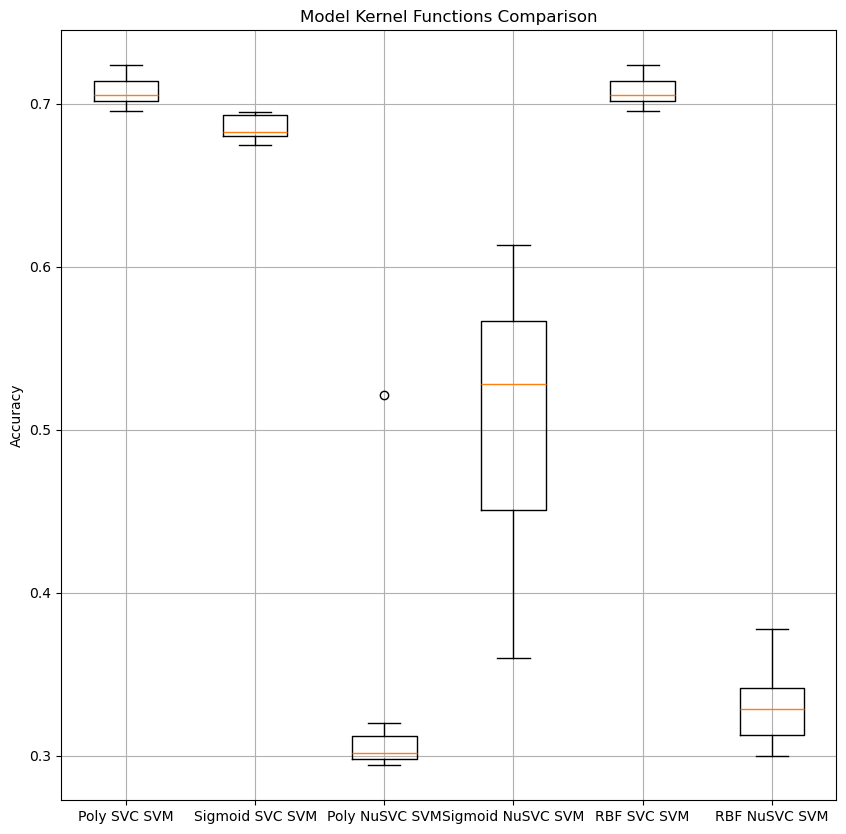

In [92]:
plt.figure(figsize=(10, 10))
plt.boxplot(kernel_results + results)
plt.title('Model Kernel Functions Comparison')
plt.ylabel('Accuracy')
all_names = kernel_names + names
plt.xticks(range(1, len(all_names) + 1), all_names)
plt.grid(True)
plt.show()

From the analysis of the kernel functions, so far it seems that RBF might be the best choice. However, given that the input paramters are default, tuning the paramters further can help with model accuracy.

<strong>A summary of the results:</strong>

[1] RBF SVC: Best overall given our nonlinear data. Relatively low standard deviation

[2] RBG NuSVC: Still strong, slightly worse that the previous

[3] Sigmoid SVC and NuSVM: These perform similarily to each other

[4] Poly SVC: Weaker than other models. Poly SVC in general is sensitive to regularization value C, so tuning this is of interest.

[5] Poly NuSVC: Weaker which might indicate this model is overfitting. The accuracy of the models vary widely from 0.3 and ~0.75. These tells us the models are not doing well across different folds indicating the model might be potentially overfitted.

These models have a fairly low standard devilation indicating that the model is consistent and stable across different folds. 
Further analysis such as looking at the ROC and AUC scores of these classification models is required.

<h3>Analysis of Regularization Parameter for SVCs</h3>

<strong>Background</strong>

The parameter C is used to set the amount of regularization, or a technqiue to reduce overfitting. C controls the trade-off between margin width and classification error.
Given that the Poly SVC model seems to be overfitted, we will test different regularization amounts for Poly SVC and RBF SVC (previously model accurate model). 

A low C indicates a larger margin and a model that is more tolerant for misclassification. A high C has more narrow margin making it less tolerant for error.

Source: 
https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html#sphx-glr-auto-examples-svm-plot-svm-scale-c-py

<strong>Regularization Tuning for RBF SVC Functions</strong>

In [93]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
rbf_regularization_results = []

for C in C_values:
    model = SVC(kernel='rbf', C=C, random_state=42)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy', n_jobs=-1)
    rbf_regularization_results.append(cv_results)
    print(f"C={C}: Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

C=0.001: Mean accuracy = 0.7083, Std = 0.0090
C=0.01: Mean accuracy = 0.7083, Std = 0.0090
C=0.1: Mean accuracy = 0.7083, Std = 0.0090
C=1: Mean accuracy = 0.7083, Std = 0.0090
C=10: Mean accuracy = 0.7083, Std = 0.0090
C=100: Mean accuracy = 0.7083, Std = 0.0090
C=1000: Mean accuracy = 0.7083, Std = 0.0090


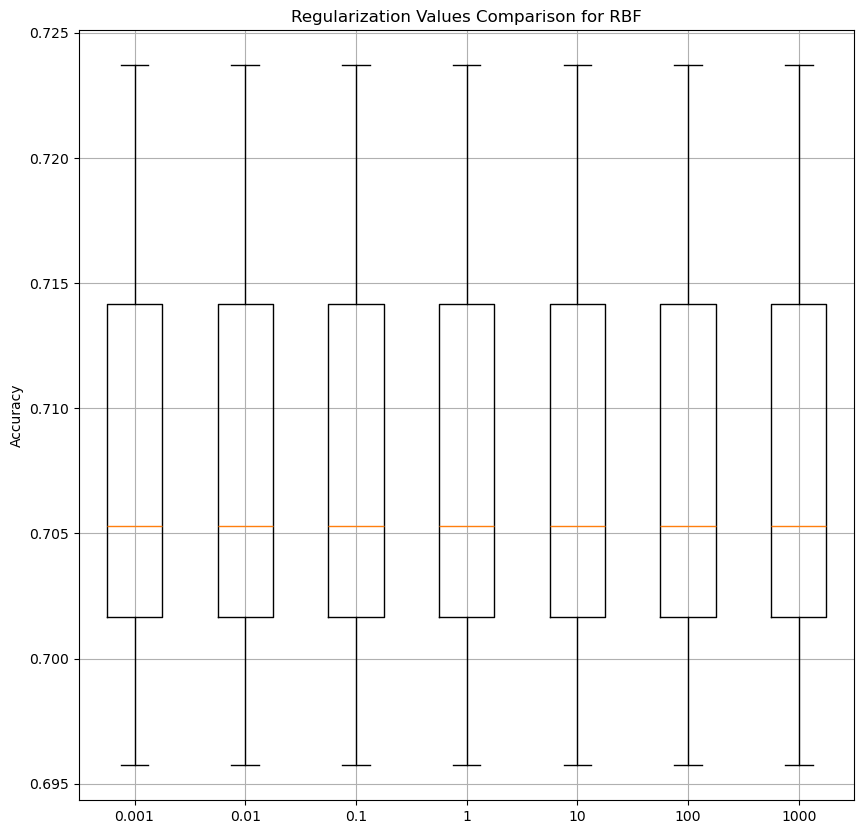

In [94]:
plt.figure(figsize=(10, 10))
plt.boxplot(rbf_regularization_results)
plt.title('Regularization Values Comparison for RBF')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(C_values) + 1), C_values)
plt.grid(True)
plt.show()

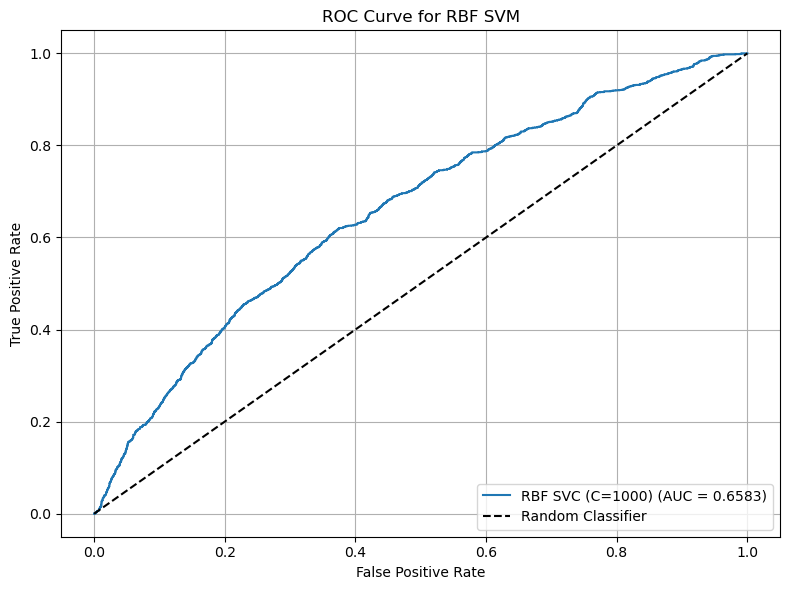

In [ ]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Fit model
model = SVC(kernel='rbf', C=1000, probability=True, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC
predictive_probability_results(y_test, y_proba, label="RBF SVC (C=1000)", title="ROC Curve for RBF SVM")

For RBF SWM, we see that as C increases, there is virtually no improvement in the model accuracy and standard deviation. 

We also observe the ROC/AUC score for the model with C=1000. The AUC score indicates that the model is close to randomly guessing. However, given other tuning paramters there is room for improvement.

<strong>Regularization Tuning for Poly SVC Functions</strong>

In [96]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
poly_regularization_results = []

for C in C_values:
    model = SVC(kernel='poly', C=C, random_state=42)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy', n_jobs=-1)
    poly_regularization_results.append(cv_results)
    print(f"C={C}: Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

C=0.001: Mean accuracy = 0.7083, Std = 0.0090
C=0.01: Mean accuracy = 0.7083, Std = 0.0090
C=0.1: Mean accuracy = 0.7083, Std = 0.0090
C=1: Mean accuracy = 0.7083, Std = 0.0090
C=10: Mean accuracy = 0.7083, Std = 0.0090
C=100: Mean accuracy = 0.7083, Std = 0.0090
C=1000: Mean accuracy = 0.7083, Std = 0.0090


The data does not seem to be overfitted as with varying values of regularization, the model performs consistently around 71% accuracy with relatively low standard deviation. It might be worth adjusting the gamma coefficient before ruling out this kernel completely.

In NuSVC, the nu parameter defines an upper bound on the fraction of margin errors and a lower bound on the fraction of support vectors.
For example, setting nu = 0.4 guarantees that no more than 40% of the training data will be margin violators, and at least 40% will be support vectors

Source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html

In [97]:
nu_value = [0.5, 0.4, 0.3]
poly_nu_regularization_results = []

for nu in nu_value:
    model = NuSVC(kernel='poly', nu=nu, random_state=42)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy', n_jobs=1)
    poly_nu_regularization_results.append(cv_results)
    print(f"Nu={nu}: Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

Nu=0.5: Mean accuracy = 0.3258, Std = 0.0657
Nu=0.4: Mean accuracy = 0.3745, Std = 0.1163
Nu=0.3: Mean accuracy = 0.3660, Std = 0.1089


We see that varying the nu value yeilds a mean accuracy of about ~35%. The highest standard deviation of 11.6 indicates instability across folds. From here, it is work considering a different kernal.

<h3>Analysis of Gamma Parameter for SVCs</h3>
<strong>Gamma Parameter Notes</strong>
This play a crucial role in defing the behavior of the decision boundary. 

A low gamma means the influence of a single training example reach far and affects a larger region of feature space. This means smoother and less complex decision boundaries. This can lead to underfitting.

A high gamma makes the decision boundary very tight around individual data points. This can lead to overfitting where the model captures noize and responds poorly to new, unseen data.

The default value of gamma is scale which is dependent on the features and variance. Auto is simply dependent on the features ignoring the actual data distribution. 

Source: https://www.geeksforgeeks.org/gamma-parameter-in-svm/


In [98]:
gamma_values = [0.0001, 0.001, 0.01, 1, 10, 100, 1000]
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
rbf_gamma_results = []
    
for gamma in gamma_values:
    for c in C_values:
        model = SVC(kernel='rbf', C=c, gamma=gamma, random_state=42)
        cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy', n_jobs=1)
        rbf_gamma_results.append(cv_results)
        print(f"gamma={gamma}, C-value={c}, Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")
    

gamma=0.0001, C-value=0.001, Mean accuracy = 0.7083, Std = 0.0090
gamma=0.0001, C-value=0.01, Mean accuracy = 0.7083, Std = 0.0090
gamma=0.0001, C-value=0.1, Mean accuracy = 0.7106, Std = 0.0102
gamma=0.0001, C-value=1, Mean accuracy = 0.7181, Std = 0.0097
gamma=0.0001, C-value=10, Mean accuracy = 0.7160, Std = 0.0093
gamma=0.0001, C-value=100, Mean accuracy = 0.7109, Std = 0.0098
gamma=0.0001, C-value=1000, Mean accuracy = 0.7024, Std = 0.0110
gamma=0.001, C-value=0.001, Mean accuracy = 0.7083, Std = 0.0090
gamma=0.001, C-value=0.01, Mean accuracy = 0.7083, Std = 0.0090
gamma=0.001, C-value=0.1, Mean accuracy = 0.7085, Std = 0.0093
gamma=0.001, C-value=1, Mean accuracy = 0.7180, Std = 0.0110
gamma=0.001, C-value=10, Mean accuracy = 0.6967, Std = 0.0079
gamma=0.001, C-value=100, Mean accuracy = 0.6865, Std = 0.0069
gamma=0.001, C-value=1000, Mean accuracy = 0.6828, Std = 0.0067
gamma=0.01, C-value=0.001, Mean accuracy = 0.7083, Std = 0.0090
gamma=0.01, C-value=0.01, Mean accuracy = 0.7

The top performer is gamma = 0.0001, C=1 with a mean accuracy of 0.7181, std=0.0097. Given that this gamma value is quite low, it indicates that our data works better with smoother decision boundaries. This provides us the best trade-off between accuracy and stability. 

We'll rerun this test with polynomial SVC, but with varying degrees. Because it did not seem that there was much difference when changing the c-value, we'll initially test with c-value of 1. Given the relationship is not highly linear, we will not test with a degree of 1, and will max out with a degree of 5. The default degree is 3, so we can disregard this.

In [ ]:
gamma_values = [0.0001, 0.001, 0.01, 1, 10, 100, 1000]
poly_degrees = [2, 4, 5]
poly_gamma_degree_results = []

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)


    
for gamma in gamma_values:
    for degree in poly_degrees:
        model = SVC(kernel='poly', C=1, gamma=gamma, degree=degree,  random_state=42, max_iter=1000)
        cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
        poly_gamma_degree_results.append(cv_results)
        print(f"gamma={gamma}, poly_degree={degree}, Mean accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=0.0001, poly_degree=2, Mean accuracy = 0.3792, Std = 0.1693


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=0.0001, poly_degree=4, Mean accuracy = 0.5142, Std = 0.0143


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=0.0001, poly_degree=5, Mean accuracy = 0.5130, Std = 0.0461


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=0.001, poly_degree=2, Mean accuracy = 0.4570, Std = 0.2034


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=0.001, poly_degree=4, Mean accuracy = nan, Std = nan


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=0.001, poly_degree=5, Mean accuracy = nan, Std = nan


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=0.01, poly_degree=2, Mean accuracy = 0.5013, Std = 0.2081


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=0.01, poly_degree=4, Mean accuracy = 0.5283, Std = 0.0391


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=0.01, poly_degree=5, Mean accuracy = nan, Std = nan


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=1, poly_degree=2, Mean accuracy = 0.3348, Std = 0.1269


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_i

gamma=1, poly_degree=4, Mean accuracy = nan, Std = nan


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py", line 276, in fit
    raise ValueError(
ValueError: The dual coefficients or intercepts are not finite. The input data may contain large values and need to be preprocessed.
